In [2]:
import os
import copy
import torch
from pathlib import Path
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import time
from torchvision import transforms
from torch.autograd import Variable
from torchvision import models, datasets, transforms
import torch.nn.functional as F

## Train/Test split

In [3]:
root = "WMTdata"
data = [im for im in Path(root, "T1_tif").glob("*.tif")]; data.sort()
annotations = [im for im in Path(root, "AnnotationsTif").glob("*.tif")]; annotations.sort()

Xtrain, Xtest, ytrain, ytest = train_test_split(data, annotations, test_size=0.20, random_state=1) #Train/Test


## Dataset

In [4]:
class Tracts(Dataset):
    """ BrainPTM
    """
    def __init__(self, datadir, maskdir, transform=None, target_transform=None):
    
        self.imgs = datadir
        self.targets= maskdir  
        assert len(self.imgs) == len(self.targets)

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self,ind):
        
        image = Image.open(self.imgs[ind]).convert("RGB")
        target = Image.open(self.targets[ind])
        #print(self.imgs[ind])
        #print(self.targets[ind])
        
        if self.transform is not None:
            image = self.transform(image)
            target = self.target_transform(target)

        return image, target



## Metrics 

In [5]:
class Evaluator(object):
    def __init__(self, num_class):
        self.num_class = num_class
        self.confusion_matrix = np.zeros((self.num_class,)*2)

    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Pixel_Accuracy_Class(self):
        Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        Acc = np.nanmean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        MIoU = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def Frequency_Weighted_Intersection_over_Union(self):
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))

        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)


## Dataloaders

In [6]:
train_loader= torch.utils.data.DataLoader(Tracts(
    Xtrain, ytrain,
    transform=transforms.ToTensor(),
    target_transform= transforms.ToTensor()
    ), batch_size=64, shuffle=True)

test_loader= torch.utils.data.DataLoader(Tracts(
    Xtest, ytest,
    transform=transforms.ToTensor(),
    target_transform= transforms.ToTensor()
    ), batch_size=64, shuffle=True)

model = models.segmentation.deeplabv3_resnet50(pretrained=False, num_classes=2)

cp_model = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.000001, momentum=0.5)
criterion = nn.CrossEntropyLoss(ignore_index=255)
metrics = Evaluator(2)


## Train/test functions

In [7]:
def train(epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        
        #if args.cuda:
        #data, target = data.cuda(), target.cuda() * 255.
        data, target = data.cuda(), target.cuda() 
        
        data, target = Variable(data), Variable(target).long().squeeze_(1)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output['out'], target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

            

def test(epoch):
    model.eval()
    metrics.reset()
    test_loss = 0.
    for data, target in test_loader:
        #if args.cuda:
        data, target = data.cuda(), target.cuda() #* 255.
        data, target = Variable(data), Variable(target).long().squeeze_(1)
        with torch.no_grad():
            output = model(data)
        test_loss += criterion(output['out'], target).item()
        pred = output['out'].cpu()
        pred = F.softmax(pred, dim=1).numpy()
        target = target.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        #if demo:
        #    out = pred[0,:,:]
        #    label = target[0,:,:]
        metrics.add_batch(target, pred)

    Acc = metrics.Pixel_Accuracy()
    Acc_class = metrics.Pixel_Accuracy_Class()
    mIoU = metrics.Mean_Intersection_over_Union()
    FWIoU = metrics.Frequency_Weighted_Intersection_over_Union()

    print('Validation:')
    print('[Epoch: %d, numImages: %5d]' % (epoch, len(test_loader.dataset)))
    print("Acc:{}, Acc_class:{}, mIoU:{}, fwIoU: {}".format(
        Acc, Acc_class, mIoU, FWIoU))
    print('Loss: %.3f' % test_loss)
    return test_loss
  
    
def adjust_learning_rate(optimizer, gamma, step):
    """Sets the learning rate to the initial LR decayed
       by 10 at every specified step
       Adapted from PyTorch Imagenet example:
       https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    lr = 0.01 * (gamma ** (step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        


## Trainning 

In [ ]:
epoch =15
best_loss = None
#if load_model:
#    best_loss = test(0)
try:
    for epoch in range(1, epoch + 1):
        epoch_start_time = time.time()
        
        train(epoch)
        test_loss = test(epoch)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s '.format(
            epoch, time.time() - epoch_start_time))
        print('-' * 89)

        if best_loss is None or test_loss < best_loss:
            best_loss = test_loss
            with open("model2.pt", 'wb') as fp:
                state = model.state_dict()
                torch.save(state, fp)
        else:
            adjust_learning_rate(optimizer, 0.5, epoch)
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')


Train Epoch: 1 [0/3696 (0%)]	Loss: 0.833463
Train Epoch: 1 [400/3696 (11%)]	Loss: 0.819305
Train Epoch: 1 [800/3696 (22%)]	Loss: 0.814612
Train Epoch: 1 [1200/3696 (32%)]	Loss: 0.810900
Train Epoch: 1 [1600/3696 (43%)]	Loss: 0.810786
Train Epoch: 1 [2000/3696 (54%)]	Loss: 0.801140
Train Epoch: 1 [2400/3696 (65%)]	Loss: 0.795103
Train Epoch: 1 [2800/3696 (76%)]	Loss: 0.788579
Train Epoch: 1 [3200/3696 (87%)]	Loss: 0.784700
Train Epoch: 1 [3600/3696 (97%)]	Loss: 0.779843
Validation:
[Epoch: 1, numImages:   924]
Acc:0.40246112304217774, Acc_class:0.5186364549625793, mIoU:0.2029616888008571, fwIoU: 0.3984926365601004
Loss: 172.084
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 281.72s 
-----------------------------------------------------------------------------------------
Train Epoch: 2 [0/3696 (0%)]	Loss: 0.784056
Train Epoch: 2 [400/3696 (11%)]	Loss: 0.776606
Train Epoch: 2 [800/3696 (22%)]	Loss: 0.771392
Train Epoch

Train Epoch: 11 [0/3696 (0%)]	Loss: 0.496714
Train Epoch: 11 [400/3696 (11%)]	Loss: 0.492307
Train Epoch: 11 [800/3696 (22%)]	Loss: 0.493428
Train Epoch: 11 [1200/3696 (32%)]	Loss: 0.492398
Train Epoch: 11 [1600/3696 (43%)]	Loss: 0.488550
Train Epoch: 11 [2000/3696 (54%)]	Loss: 0.482935
Train Epoch: 11 [2400/3696 (65%)]	Loss: 0.485030
Train Epoch: 11 [2800/3696 (76%)]	Loss: 0.484696
Train Epoch: 11 [3200/3696 (87%)]	Loss: 0.479723
Train Epoch: 11 [3600/3696 (97%)]	Loss: 0.483982
Validation:
[Epoch: 11, numImages:   924]
Acc:0.9387317417102573, Acc_class:0.5148779677890862, mIoU:0.47294073994427294, fwIoU: 0.9339430803609311
Loss: 120.514
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 281.67s 
-----------------------------------------------------------------------------------------
Train Epoch: 12 [0/3696 (0%)]	Loss: 0.476261
Train Epoch: 12 [400/3696 (11%)]	Loss: 0.469355
Train Epoch: 12 [800/3696 (22%)]	Loss: 0.4523

Validation:
[Epoch: 20, numImages:   924]
Acc:0.9948884891511844, Acc_class:0.5, mIoU:0.4974442445755922, fwIoU: 0.9898031058455264
Loss: 52.938
-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 288.19s 
-----------------------------------------------------------------------------------------
Train Epoch: 21 [0/3696 (0%)]	Loss: 0.155528
Train Epoch: 21 [400/3696 (11%)]	Loss: 0.142538
Train Epoch: 21 [800/3696 (22%)]	Loss: 0.149166
Train Epoch: 21 [1200/3696 (32%)]	Loss: 0.140016
Train Epoch: 21 [1600/3696 (43%)]	Loss: 0.157674
Train Epoch: 21 [2000/3696 (54%)]	Loss: 0.138114
Train Epoch: 21 [2400/3696 (65%)]	Loss: 0.138496
Train Epoch: 21 [2800/3696 (76%)]	Loss: 0.136193
Train Epoch: 21 [3200/3696 (87%)]	Loss: 0.132024
Train Epoch: 21 [3600/3696 (97%)]	Loss: 0.146318
Validation:
[Epoch: 21, numImages:   924]
Acc:0.9948884891511844, Acc_class:0.5, mIoU:0.4974442445755922, fwIoU: 0.9898031058455264
Loss: 51.032
----------

Train Epoch: 30 [2000/3696 (54%)]	Loss: 0.095110
Train Epoch: 30 [2400/3696 (65%)]	Loss: 0.094764
Train Epoch: 30 [2800/3696 (76%)]	Loss: 0.097335
Train Epoch: 30 [3200/3696 (87%)]	Loss: 0.095962
Train Epoch: 30 [3600/3696 (97%)]	Loss: 0.077044
Validation:
[Epoch: 30, numImages:   924]
Acc:0.9948884891511844, Acc_class:0.5, mIoU:0.4974442445755922, fwIoU: 0.9898031058455264
Loss: 37.197
-----------------------------------------------------------------------------------------
| end of epoch  30 | time: 288.31s 
-----------------------------------------------------------------------------------------
Train Epoch: 31 [0/3696 (0%)]	Loss: 0.087937
Train Epoch: 31 [400/3696 (11%)]	Loss: 0.090727
Train Epoch: 31 [800/3696 (22%)]	Loss: 0.093825
Train Epoch: 31 [1200/3696 (32%)]	Loss: 0.087951
Train Epoch: 31 [1600/3696 (43%)]	Loss: 0.075064
Train Epoch: 31 [2000/3696 (54%)]	Loss: 0.090388
Train Epoch: 31 [2400/3696 (65%)]	Loss: 0.094324
Train Epoch: 31 [2800/3696 (76%)]	Loss: 0.100838
Train Ep

## Testing 

In [8]:
#Load model 
with open("model2.pt", 'rb') as fp:
    state = torch.load(fp)
    model.load_state_dict(state)
    load_model = True
    
    
#Test
epoch_start_time = time.time()
test_loss = test(1)
print('-' * 89)
print('| end of epoch {:3d} | time: {:5.2f}s '.format(
    1, time.time() - epoch_start_time))
print('-' * 89)



Validation:
[Epoch: 1, numImages:   924]
Acc:0.9948884891511844, Acc_class:0.5, mIoU:0.4974442445755922, fwIoU: 0.9898031058455264
Loss: 2.024
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 32.78s 
-----------------------------------------------------------------------------------------


## Inference 

In [31]:
out=np.empty([128,144])
out.shape

(128, 144)

In [9]:
demo = True
out=np.empty([128,144])
label=np.empty([128,144])
#Test
epoch_start_time = time.time()
test_loss = test(1)
print('-' * 89)
print('| end of epoch {:3d} | time: {:5.2f}s '.format(
    1, time.time() - epoch_start_time))
print('-' * 89)

demo=False

Validation:
[Epoch: 1, numImages:   924]
Acc:0.9948884891511844, Acc_class:0.5, mIoU:0.4974442445755922, fwIoU: 0.9898031058455264
Loss: 2.028
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 16.64s 
-----------------------------------------------------------------------------------------


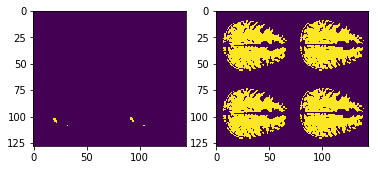

In [10]:
plt.subplot(121)
plt.imshow(out)
plt.subplot(122)
plt.imshow(label)

In [ ]:
#Load model 
with open("model.pt", 'rb') as fp:
    state = torch.load(fp)
    model.load_state_dict(state)
    load_model = True
    
    
#Test
epoch_start_time = time.time()
test_loss = test(1)
print('-' * 89)
print('| end of epoch {:3d} | time: {:5.2f}s '.format(
    1, time.time() - epoch_start_time))
print('-' * 89)


## Dataset creation 

In [87]:

class WMSegmentation(Dataset):
    def __init__(self,filenames,masknames,transform=None):
        
        self.image_names = filenames
        self.mask_names = masknames
        self.transform= transform
        

    def __len__(self):
        assert len(self.image_names) == len(self.mask_names)
        
        return len(self.image_names)

    def __getitem__(self, idx):
        image = self.image_names[idx]
        mask = self.mask_names[idx]
        
        image = Image.open(image)
        mask= Image.open(mask)
        
        # Add transformations
        if self.transform:
            image = self.transform(image); #image = torch.cat((image,image,image),0)
            mask = self.transform(mask)[0,:,:];# mask = torch.cat((mask,mask,mask),0)
        
        sample = {"image": image, "mask":mask }
        
        
        return sample



In [88]:


train_dataloader = DataLoader(WMSegmentation(
    Xtrain,ytrain,transform = transforms.ToTensor()),
                              batch_size=4, shuffle=True)

In [102]:
image = Image.open(ytrain[2])
transform = transforms.ToTensor()
im = transform(image)

print(im.shape)
im2 = torch.cat((im,im,im),0)
im2.shape

np.unique(im)

torch.Size([1, 128, 144])


array([0., 1.], dtype=float32)

## Model 

In [103]:
""" DeepLabv3 Model download and change the head for your prediction"""
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models


def createDeepLabv3(outputchannels=2):
    """DeepLabv3 class with custom head
    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.
    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

In [90]:
net = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana')


Using cache found in /home/fjmoya/.cache/torch/hub/milesial_Pytorch-UNet_master


In [66]:
net

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

## Training method 

In [104]:

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


my_cnn = createDeepLabv3()
my_cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_cnn.parameters(), lr=0.001, momentum=0.9)
start_time = time.time()


for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, masks = data['image'].to(device), data['mask'].to(device)
        #inputs, labels = data['image'], data['label']
       

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = my_cnn(inputs)["out"]
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2 == 1.99:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2))
            running_loss = 0.0

print('Finished Training')


end_time = time.time()
print(f"The execution time is: {end_time-start_time}")

cuda:0


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target'

In [32]:
def train_model(model, criterion, dataloaders, optimizer, metrics, bpath,
                num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            # Iterate over data.
            for sample in tqdm(iter(dataloaders[phase])):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs['out'], masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            # Use a classification threshold of 0.1
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model